## Question1

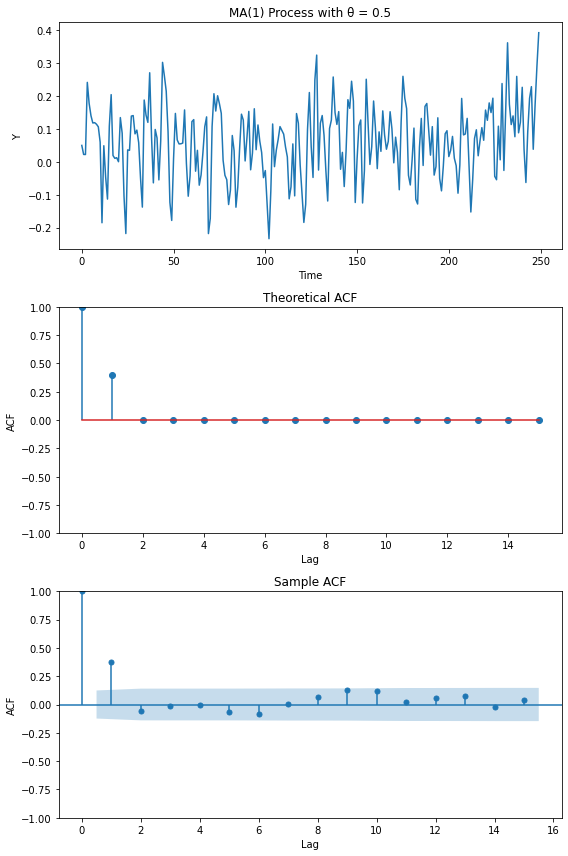

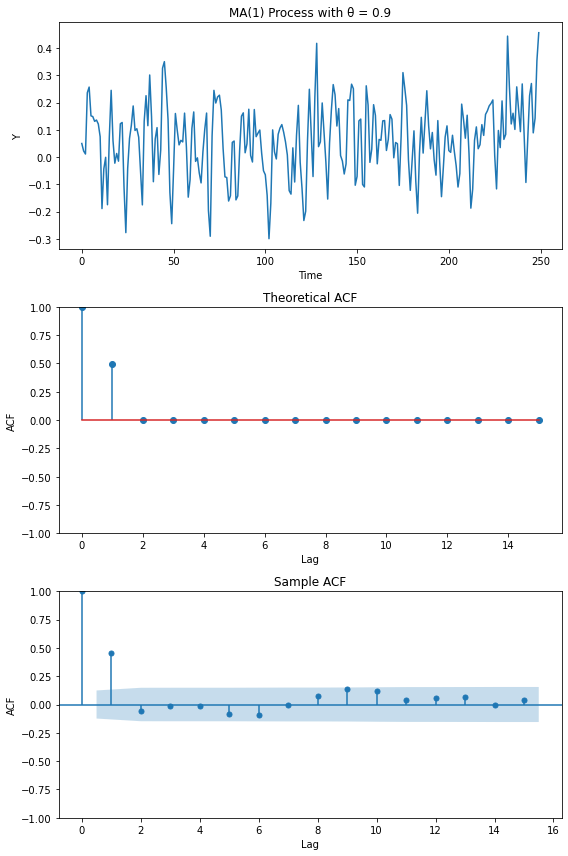

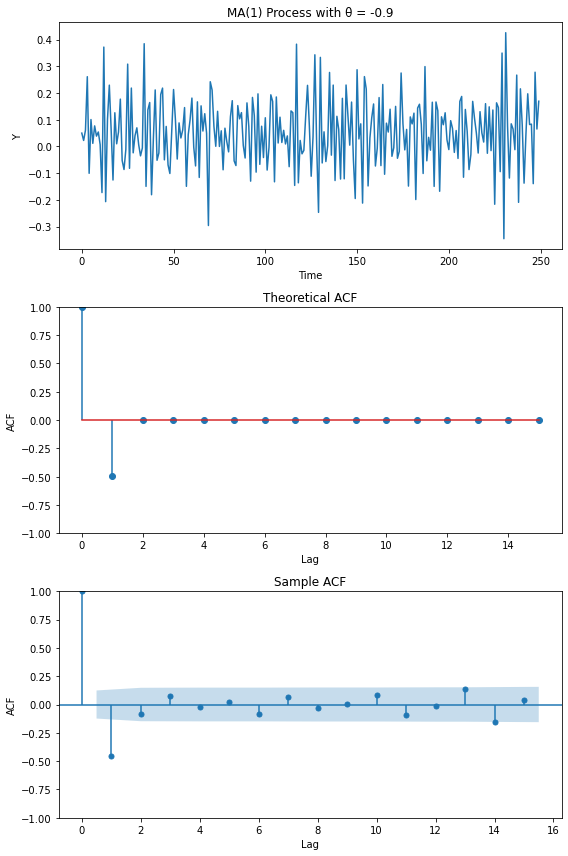

In [1]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima_process import arma_generate_sample
def ma1_plot(theta):
    np.random.seed(2022)
    
    # Define the parameters
    const = 0.05
    sigma = 0.1
    
    # Simulate the MA(1) process
    ar = np.array([1])
    ma = np.array([1, theta])
    armap = ArmaProcess(ar, ma)
    y = const + armap.generate_sample(nsample=250, scale=sigma)
    
    # Plot the time series
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,12))
    ax[0].plot(y)
    ax[0].set(title="MA(1) Process with θ = {}".format(theta), xlabel="Time", ylabel="Y")
    
    # Plot the theoretical ACF
    theoretical_acf = np.array([1, theta/(1+theta**2)] + [0]*14)
    ax[1].stem(theoretical_acf, use_line_collection=True)
    ax[1].set(title="Theoretical ACF", xlabel="Lag", ylabel="ACF", ylim=(-1, 1))
    
    # Plot the sample ACF
    plot_acf(y, lags=15, ax=ax[2])
    ax[2].set(title="Sample ACF", xlabel="Lag", ylabel="ACF")
    
    plt.tight_layout()
    plt.show()
    
# Plot the ACF for phi = 0.5
ma1_plot(0.5)

# Plot the ACF for phi = 0.9
ma1_plot(0.9)

# Plot the ACF for phi = -0.9
ma1_plot(-0.9)

## Question2

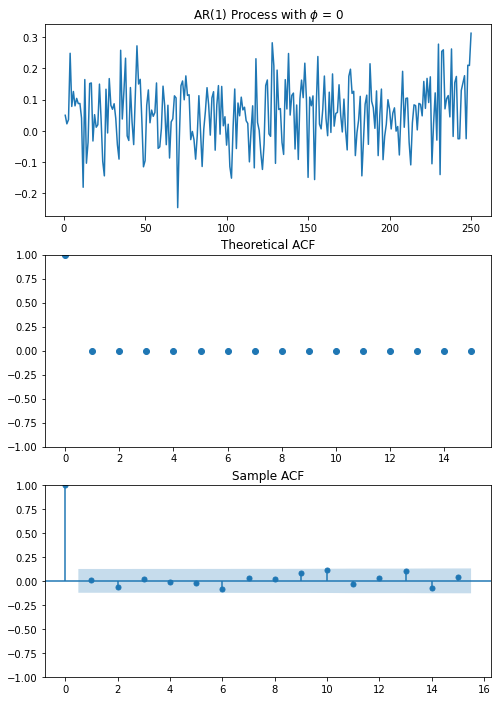

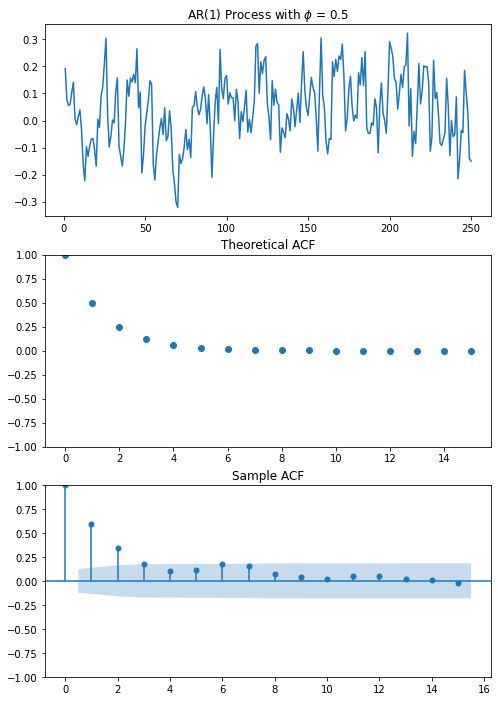

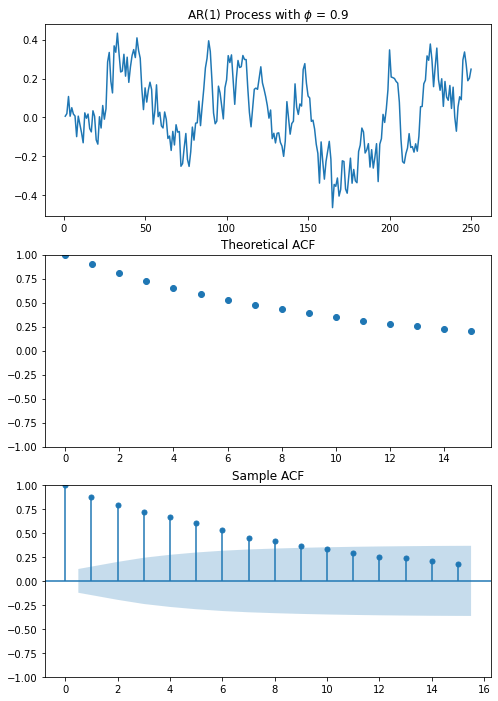

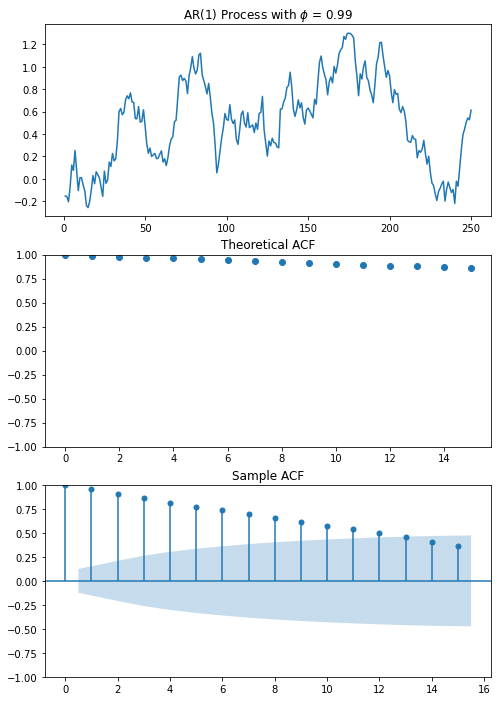

In [2]:
def ar1_plot(phi):
    ar = np.r_[1, -phi] # add zero-lag and negate
    ma = np.r_[1] # add zero-lag
    y = 0.05 + arma_generate_sample(ar, ma, scale = 0.1, nsample = 250)

    fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(8,12))
    ax[0].plot(np.arange(1, 251, 1), y) # first subgraph
    ax[0].set_title(r'AR(1) Process with $\phi$ = {}'.format(phi)) 

    theoretical_acf = phi ** np.arange(0, 16, 1)
    ax[1].scatter(np.arange(0, 16, 1), theoretical_acf)
    ax[1].set_ylim([-1.0, 1.0])
    ax[1].set_title('Theoretical ACF')

    plot_acf(y, lags = 15, ax = ax[2]) 
    ax[2].set_title('Sample ACF')
    plt.show()

np.random.seed(2022)

ar1_plot(0)
ar1_plot(0.5)
ar1_plot(0.9)
ar1_plot(0.99)

## Question3

In [4]:
import yfinance as yf
import numpy as np
from scipy.stats import iqr, norm
import datetime
import pandas as pd
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2021, 3, 6)

df = yf.download("KO", start=start, end=end,interval='1wk')#, auto_adjust=True)
df.reset_index(inplace=True)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Calculate the weekly log returns
cc = np.log(df['Adj Close']/df['Adj Close'].shift(1)).dropna()

# Convert cc to a numpy array
cc = np.array(cc)


[*********************100%***********************]  1 of 1 completed


(a)

In [5]:
from statsmodels.stats.diagnostic import acorr_ljungbox
print(acorr_ljungbox(cc, lags=[10], return_df=True))
print('Reject Null hpothesis, it is not white noise')

      lb_stat  lb_pvalue
10  23.987549   0.007634
Reject Null hpothesis, it is not white noise


(b)

In [6]:
from statsmodels.tsa.arima.model import ARIMA
res = ARIMA(cc, order=(0, 0, 1)).fit() 
print(acorr_ljungbox(res.resid, lags=[10], return_df=True))
print('Reject Null hypothesis, it is not white noise.')

      lb_stat  lb_pvalue
10  21.168589   0.019948
Reject Null hypothesis, it is not white noise.


(c)

In [7]:
import pmdarima as pm
import pandas as pd

# Fit a ARMA model using pmdarima
model = pm.auto_arima(cc, start_p=0, start_q=1, d=0, max_p=0, max_q=10, stepwise=True)

# Print model summary
print(model.summary())

# Extract model coefficients, standard errors, and p-values from summary table
summary_table = model.summary().tables[1]
table_df = pd.DataFrame(summary_table.data[1:], columns=summary_table.data[0])
coef = table_df['coef'].astype(float).values
se = table_df['std err'].astype(float).values
p_vals = table_df['P>|z|'].astype(float).values


# Calculate z-scores and print them along with p-values
z_scores = (coef - 0) / se
print(z_scores)
print(p_vals)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  583
Model:               SARIMAX(0, 0, 1)   Log Likelihood                1373.730
Date:                Mon, 13 Mar 2023   AIC                          -2741.460
Time:                        14:10:24   BIC                          -2728.355
Sample:                             0   HQIC                         -2736.352
                                - 583                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.001      1.631      0.103      -0.000       0.004
ma.L1         -0.0784      0.019     -4.128      0.000      -0.116      -0.041
sigma2         0.0005   1.39e-05     37.712      0.0

In [8]:
# Set significance level
alpha = 0.05

# Perform t-test for each coefficient
for i in range(len(coef)):
 
    print("Coefficient {}: t={}, p={}".format(i+1, z_scores[i],p_vals[i] ))
    if p_vals[i] < alpha:
        print("Reject null hypothesis for coefficient {}".format(i+1))
    else:
        print("Fail to reject null hypothesis for coefficient {}".format(i+1))

print('The optimal lag is:',1)

Coefficient 1: t=1.6, p=0.103
Fail to reject null hypothesis for coefficient 1
Coefficient 2: t=-4.126315789473685, p=0.0
Reject null hypothesis for coefficient 2
Coefficient 3: t=35.97122302158273, p=0.0
Reject null hypothesis for coefficient 3
The optimal lag is: 1


(d)

<Figure size 432x288 with 0 Axes>

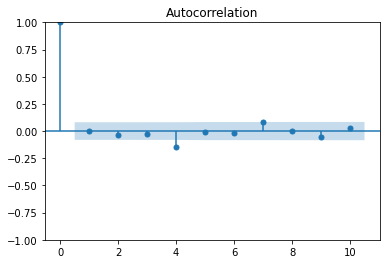

      lb_stat  lb_pvalue
10  21.189412   0.019811
Reject null hypothesis, the model is not linear dependence.


In [9]:
plt.figure()
plot_acf(model.resid(), lags = 10)
plt.show()
print(acorr_ljungbox(model.resid(), lags=[10], return_df=True))
print('Reject null hypothesis, the model is not linear dependence.')

(e)

In [10]:
model = pm.auto_arima(cc, start_p=1, start_q=1, d=0, max_p=10, max_q=10, stepwise=True)

# Print model summary
print(model.summary())

# Perform Ljung-Box test on residuals
lb_test = acorr_ljungbox(model.resid(), lags=[10], return_df=True)

# Print results of Ljung-Box test
print(lb_test)
print('Fail to reject null hypothesis, the model is linear dependence.')

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  583
Model:               SARIMAX(1, 0, 2)   Log Likelihood                1377.847
Date:                Mon, 13 Mar 2023   AIC                          -2745.694
Time:                        14:10:27   BIC                          -2723.853
Sample:                             0   HQIC                         -2737.181
                                - 583                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001   8.23e-05      1.619      0.105    -2.8e-05       0.000
ar.L1          0.9180      0.048     19.090      0.000       0.824       1.012
ma.L1         -0.9869      0.055    -17.880      0.0

(f)

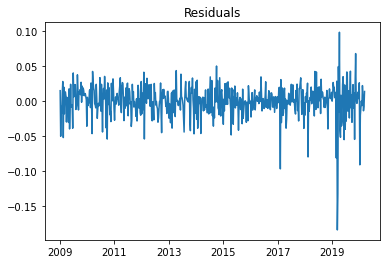

In [11]:
import matplotlib.pyplot as plt

# Plot residuals
plt.plot(df['Date'].iloc[1:], model.resid())
plt.title('Residuals')
plt.show()

Based on the plot of the residuals, it appears that there is still some autocorrelation in the residuals, which may suggest that the ARMA model is not capturing all the patterns in the data. Additionally, there are some large positive and negative spikes in the residuals, which suggests that the model may be underestimating the volatility in the data.